# Implementing PINN for 1 qubit system

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

In [3]:
df = pd.read_csv('1q.txt')
df.head()

,time,rho_ee,rho_gg,coh_eg,coh_ge,omega_x,gamma
0,0.00,1.000000,0.000000,0j,-0j,2.5,1.0
1,0.01,0.989432,0.010568,0.024678542336111022j,-0.024678542336111022j,2.5,1.0
2,0.02,0.977758,0.022242,0.048679136637985995j,-0.048679136637985995j,2.5,1.0
3,0.03,0.965025,0.034975,0.07195114933950349j,-0.07195114933950349j,2.5,1.0
4,0.04,0.951279,0.048721,0.09444653905769743j,-0.09444653905769743j,2.5,1.0


In [4]:
coh_eg = np.array(df['coh_eg'],dtype=complex)
df['coh_eg'] = coh_eg

coh_ge = np.array(df['coh_ge'],dtype=complex)
df['coh_ge'] = coh_ge


In [5]:
df.tail()

,time,rho_ee,rho_gg,coh_eg,coh_ge,omega_x,gamma
396,3.96,0.500853,0.499147,0.000000-0.073889j,0.000000+0.073889j,2.5,1.0
397,3.97,0.499535,0.500465,0.000000-0.073511j,0.000000+0.073511j,2.5,1.0
398,3.98,0.498214,0.501786,0.000000-0.073200j,0.000000+0.073200j,2.5,1.0
399,3.99,0.496892,0.503108,0.000000-0.072957j,0.000000+0.072957j,2.5,1.0
400,4.00,0.495573,0.504427,0.000000-0.072782j,0.000000+0.072782j,2.5,1.0


In [6]:
t_axis = np.array(df['time'].values)
t_axis.shape

(401,)

# PINN MLP
<hr/>

In [7]:
import numpy as onp
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, jacfwd, jacrev
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange 

import scipy.io
from scipy.interpolate import griddata
from scipy.linalg import lstsq
from scipy.optimize import lsq_linear
from sklearn.linear_model import RidgeCV
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.optimize import  least_squares

from scipy.integrate import odeint  as scipy_odeint
from mpl_toolkits.mplot3d import Axes3D

In [8]:
from jax.lib import xla_bridge
from jax import device_get

print('device: ', jax.devices())
print('platform: ', jax.default_backend())


# a quick GPU-heavy op
a = np.ones((2000,2000))
b = np.ones((2000,2000))
c = a @ b   # JAX builds the computation; will run on GPU when executed
print("result shape:", c.shape)
# force execution and transfer small scalar to host
print("sum:", float(device_get(c.sum())))

/tmp/ipykernel_7468/1954096156.py:1: DeprecationWarning: jax.lib.xla_bridge module will be removed in JAX v0.9.0; all its APIs were deprecated and removed by JAX v0.8.0.
  from jax.lib import xla_bridge


device:  [CudaDevice(id=0)]
platform:  gpu
result shape: (2000, 2000)
sum: 8000000000.0


In [141]:
def MLP(layers, activation=np.tanh):

    def init_layer(key, d_in, d_out):

        k1, _ = random.split(key)

        glorot_stddev = 1.0 / np.sqrt((d_in + d_out)/2.0)

        W = glorot_stddev * random.normal(k1, (d_in, d_out))
        b = np.zeros(d_out)

        return W, b
    
    def init(rng_key):

        _, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))

        return params
    
    def apply(params, inputs):

        for W,b in params[:-1]:
            output = np.dot(inputs, W) + b
            inputs = activation(output)

        W,b = params[-1]
        output = np.dot(inputs, W) + b
        
        return output

    return init, apply 

In [142]:
class PINN:

    # --------------------------------------------------------------------------------#
    # Properties of the PINN                                                          #
    # --------------------------------------------------------------------------------#
    def __init__(self, layers, states0, t0, t1, tol):
        
        self.states0 = states0
        self.t0 = t0
        self.t1 = t1

        self.trace_lambda = 0.000001
        self.resid_lambda = 1.0

        # grid
        n_t = 300
        eps = self.t1 * 0.1
        self.t = np.linspace(self.t0, self.t1 + eps, n_t)

        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol

        # hamiltonain and meta-parameters
        self.sigma_x = np.array([[0,1],[1,0]], dtype=np.complex64)
        self.omega_x = 2.5
        self.H = self.omega_x * self.sigma_x

        self.sigma_minus = np.array([[0,1],[0, 0]], dtype=np.complex64)
        self.gamma = 1.0
        self.L = self.sigma_minus


        self.init, self.apply = MLP(layers, activation=np.tanh)

        params = self.init(random.PRNGKey(1234))

        # optimizare properties
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-4, decay_steps=5000, decay_rate=0.9))

        self.opt_state = self.opt_init(params)
        _, self.unravel = ravel_pytree(params)

        # logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_res_log = []


    # --------------------------------------------------------------------------------#
    # Define Nueral Networks and Get Functions                                        #
    # --------------------------------------------------------------------------------#
    def neural_net(self, params, t):

        t = np.stack([t])

        outputs = self.apply(params, t) * t

        rho00 = outputs[0]
        rho01_re = outputs[1]
        rho01_im = outputs[2]

        rho00_ic = self.states0[0]
        rho01_re_ic = self.states0[1]
        rho01_im_ic = self.states0[2]

        rho00 = rho00 + rho00_ic
        rho01 = (rho01_re + rho01_re_ic) + 1j*(rho01_im + rho01_im_ic)

        return rho00, rho01.real, rho01.imag
    
    def rho00_fn(self, params, t):
        rho00 = self.neural_net(params, t)[0]
        return rho00

    def rho01_real_fn(self, params, t):
        rho01_re = self.neural_net(params, t)[1]
        return rho01_re

    def rho01_imag_fn(self, params, t):
        rho01_im = self.neural_net(params, t)[2]
        return rho01_im
    
    # --------------------------------------------------------------------------------#
    # Lindblad Master Equations                                                       #
    # --------------------------------------------------------------------------------#
    def lindblad_rhs(self, rho):

        comm = -1j * (self.H @ rho - rho @ self.H)
        LL = self.L.conj().T @ self.L
        dissipation = self.gamma * (self.L @ rho @ self.L.conj().T - 0.5 * (LL @ rho + rho @ LL))

        return comm + dissipation
      
    def lindblad_loss(self, rho, drho_dt):

        rhs = self.lindblad_rhs(rho)
        R = drho_dt - rhs

        return np.real(np.trace(R.conj().T @ R))


    # --------------------------------------------------------------------------------#
    # Construct Rho and calculate Residual Loss                                       #
    # --------------------------------------------------------------------------------#
    @partial(jit, static_argnums=(0,))
    def residual_net(self, params, t):

        # predictions
        rho00, rho01_re, rho01_im = self.neural_net(params, t)
        rho01 = rho01_re + 1j*rho01_im

        # time derivates
        rho00_t = grad(self.rho00_fn, argnums=1)(params, t)
        rho01_re_t = grad(self.rho01_real_fn, argnums=1)(params, t)
        rho01_im_t = grad(self.rho01_imag_fn, argnums=1)(params, t)
        rho01_t = rho01_re_t + 1j*rho01_im_t

        # conjugates
        rho10 = np.conj(rho01)
        rho10_t = np.conj(rho01_t)

        # build 2x2 complex matrices
        rho = np.array([[rho00, rho01],
                        [rho10, 1 - rho00]], dtype=np.complex64)

        drho_dt = np.array([[rho00_t, rho01_t],
                            [rho10_t, -rho00_t]], dtype=np.complex64)

        loss = self.lindblad_loss(rho, drho_dt)

        # trace loss
        # if self.trace_lambda > 0.0:
        #     tr = np.real(np.trace(rho))
        #     loss = self.resid_lambda * loss + self.trace_lambda * (tr - 1.0)**2

        return 1000*loss
    

    # --------------------------------------------------------------------------------#
    # Causal Training and construction of Different Loss                              #
    # --------------------------------------------------------------------------------#    
    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):

        rho_res = vmap(self.residual_net, (None, 0))(params, self.t)

        W = lax.stop_gradient(np.exp( - tol * self.M @ (rho_res)))

        return rho_res, W
    
    @partial(jit, static_argnums=(0,))
    def loss_res(self, params):

        rho_res, W = self.residuals_and_weights(params, self.tol)
        loss_res = np.mean(W * (rho_res))

        return loss_res
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params):

        loss_res = self.loss_res(params)

        loss = loss_res

        return loss


    # --------------------------------------------------------------------------------#
    # Update/Optimizer step                                                           #
    # --------------------------------------------------------------------------------#
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):

        params = self.get_params(opt_state)
        g = grad(self.loss)(params)

        return self.opt_update(i, g, opt_state)

    # --------------------------------------------------------------------------------#
    # Training Loop                                                                   #
    # --------------------------------------------------------------------------------#
    def train(self, nIter=10000):

        pbar = trange(nIter)

        for it in pbar:

            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)

            if it % 1000 == 0:

                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_res_value = self.loss_res(params)

                _, W_value = self.residuals_and_weights(params, self.tol)

                loss_value.block_until_ready()
                loss_res_value.block_until_ready()
                W_value.block_until_ready()
            
                loss_value_h = float(device_get(loss_value))
                loss_res_value_h = float(device_get(loss_res_value))
                W_value_h = device_get(W_value)

                self.loss_log.append(loss_value_h)
                self.loss_res_log.append(loss_res_value_h)

                pbar.set_postfix({
                    'L' : loss_value_h,
                    'RES' : loss_res_value_h,
                    'W_min' : float(W_value_h.min()),
                })

                if float(W_value_h.min()) > 0.99:
                    break


    # --------------------------------------------------------------------------------#
    # Predictions                                                                     #
    # --------------------------------------------------------------------------------#
    @partial(jit, static_argnums=(0,))
    def predict_u(self, params, t_star):

        rho00_pred, rho01_re_pred, rho01_im_pred = vmap(self.neural_net, (None, 0))(params, t_star)

        return rho00_pred, rho01_re_pred, rho01_im_pred

# Training and Training-parameters
<hr/>

In [143]:
t0 = 0.0
t1 = 1.0

tol = 0.1
tol_list = [1e-3, 1e-2, 1e-1, 1e-0] # there was a 1e-3

layers = [1, 128, 128, 128, 3]

rho00_pred_list = []
rho01_re_pred_list = []
rho01_im_pred_list = []
params_list = []
losses_list = []

state0 = np.array([df['rho_gg'][0],df['coh_ge'][0].real, df['coh_ge'][0].imag])
T = 4
t = np.round(np.arange(t0, t1, 0.01),2)

print(t.shape)

state0

(100,)


Array([ 0.,  0., -0.], dtype=float32)

Final Time: 1.0
[ 0.  0. -0.]
tol :  0.001


 32%|███▏      | 32000/100000 [00:10<00:23, 2942.64it/s, L=0.0325, RES=0.0325, W_min=0.991]


tol :  0.01


100%|██████████| 100000/100000 [00:26<00:00, 3807.75it/s, L=0.00939, RES=0.00939, W_min=0.974]


tol :  0.1


100%|██████████| 100000/100000 [00:26<00:00, 3809.83it/s, L=0.0072, RES=0.0072, W_min=0.814] 


tol :  1.0


100%|██████████| 100000/100000 [00:26<00:00, 3808.24it/s, L=0.00706, RES=0.00706, W_min=0.131]


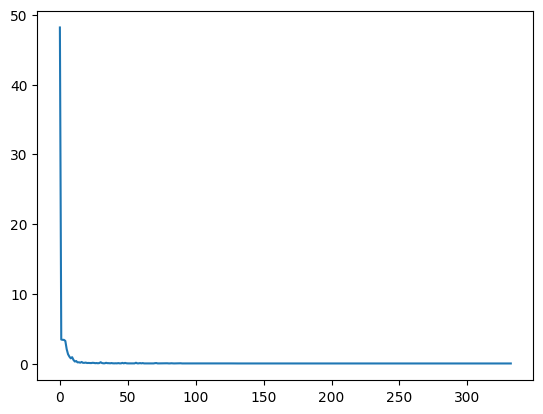

1.0
Relative l2 error rho00: 1.823e-04
Relative l2 error rho01_re: 7.286e+01
Relative l2 error rho01_im: 4.667e-04
Final Time: 2.0
[3.8668412e-01 1.3007503e-04 3.1865275e-01]
tol :  0.001


 35%|███▌      | 35000/100000 [00:11<00:21, 3000.96it/s, L=0.0352, RES=0.0352, W_min=0.99] 


tol :  0.01


100%|██████████| 100000/100000 [00:26<00:00, 3820.00it/s, L=0.00722, RES=0.00722, W_min=0.979]


tol :  0.1


100%|██████████| 100000/100000 [00:26<00:00, 3818.15it/s, L=0.00584, RES=0.00584, W_min=0.849]


tol :  1.0


100%|██████████| 100000/100000 [00:26<00:00, 3792.91it/s, L=0.0049, RES=0.0049, W_min=0.251] 


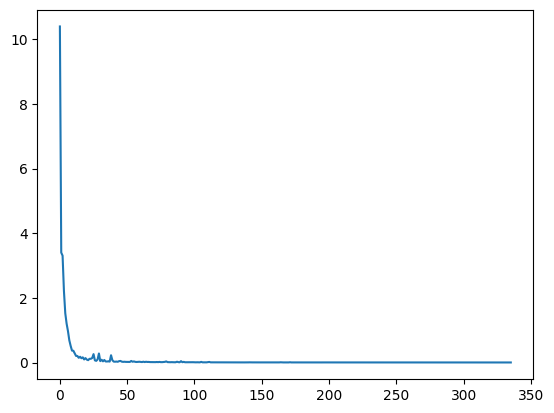

2.0
Relative l2 error rho00: 3.151e-04
Relative l2 error rho01_re: 1.304e+02
Relative l2 error rho01_im: 9.400e-04
Final Time: 3.0
[ 5.9117442e-01 -1.2998469e-05  1.7794764e-01]
tol :  0.001


 46%|████▌     | 46000/100000 [00:14<00:17, 3154.97it/s, L=0.0327, RES=0.0327, W_min=0.991]


tol :  0.01


100%|██████████| 100000/100000 [00:26<00:00, 3812.80it/s, L=0.00806, RES=0.00806, W_min=0.976]


tol :  0.1


100%|██████████| 100000/100000 [00:26<00:00, 3814.32it/s, L=0.00526, RES=0.00526, W_min=0.857]


tol :  1.0


100%|██████████| 100000/100000 [00:26<00:00, 3817.26it/s, L=0.00546, RES=0.00546, W_min=0.201]


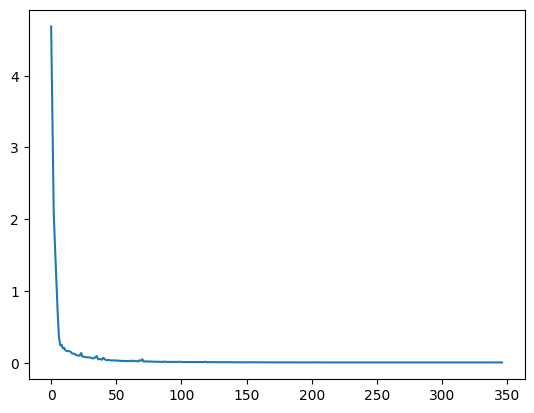

3.0
Relative l2 error rho00: 2.922e-04
Relative l2 error rho01_re: 1.401e+02
Relative l2 error rho01_im: 9.490e-04
Final Time: 4.0
[5.587501e-01 1.234198e-04 6.972657e-02]
tol :  0.001


 18%|█▊        | 18000/100000 [00:07<00:33, 2415.43it/s, L=0.0311, RES=0.0311, W_min=0.991]


tol :  0.01


100%|██████████| 100000/100000 [00:26<00:00, 3814.52it/s, L=0.0072, RES=0.0072, W_min=0.98]  


tol :  0.1


100%|██████████| 100000/100000 [00:26<00:00, 3806.42it/s, L=0.00439, RES=0.00439, W_min=0.88]


tol :  1.0


100%|██████████| 100000/100000 [00:26<00:00, 3803.15it/s, L=0.00487, RES=0.00487, W_min=0.243]


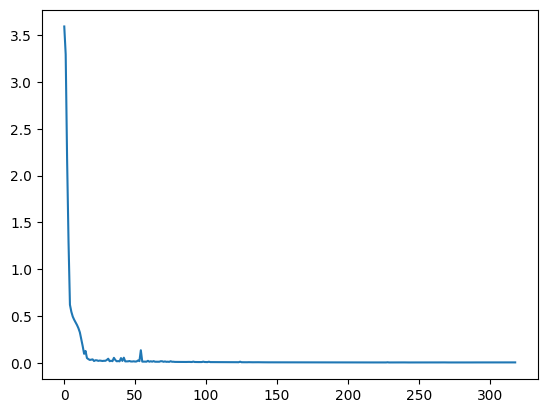

4.0
Relative l2 error rho00: 2.721e-04
Relative l2 error rho01_re: 1.744e+02
Relative l2 error rho01_im: 9.741e-04


In [144]:
for k in range(int(T/t1)):

    # initialize model
    print('Final Time: {}'.format( (k+1) * t1))
    model = PINN(layers, state0, t0, t1, tol)

    print(state0)

    for tol in tol_list:
        model.tol = tol
        print('tol : ', model.tol)

        model.train(nIter=100000)

    params = model.get_params(model.opt_state)
    rho00_pred, rho01_re_pred, rho01_im_pred = model.predict_u(params, t)
    rho00_0_pred, rho01_0_re_pred, rho01_0_im_pred = model.neural_net(params, model.t1)
    state0 = np.array([rho00_0_pred, rho01_0_re_pred, rho01_0_im_pred])

    # store predictions
    rho00_pred_list.append(rho00_pred)
    rho01_re_pred_list.append(rho01_re_pred)
    rho01_im_pred_list.append(rho01_im_pred)
    losses_list.append(model.loss_res_log)

    # store params
    flat_params, _ = ravel_pytree(params)
    params_list.append(flat_params)

    np.save('rho00_pred_list.npy', rho00_pred_list)
    np.save('rho01_re_pred_list.npy', rho01_re_pred_list)
    np.save('rho01_im_pred_list.npy', rho01_im_pred_list)
    np.save('params_list.npy', params_list)
    np.save('losses_list.npy', onp.array(losses_list, dtype=object), allow_pickle=True)

    plt.plot(np.arange(0, len(model.loss_log), 1),model.loss_log)
    plt.show()
    # error
    # Build host (NumPy) concatenated predictions
    rho00_preds = onp.hstack([onp.asarray(x) for x in rho00_pred_list])
    rho01_re_preds = onp.hstack([onp.asarray(z) for z in rho01_re_pred_list])
    rho01_im_preds = onp.hstack([onp.asarray(y) for y in rho01_im_pred_list])

    idx_t0 = df['time'].loc[df['time'] == t0].index[0]

    t_f = onp.round((k+1)*t1 ,2)
    print(t_f)

    idx_t1 = df['time'].loc[df['time'] == t_f].index[0]

    # Get reference states (host numpy)
    states = np.array([df['rho_gg'][idx_t0:idx_t1].values, df['coh_ge'][idx_t0:idx_t1].values.real, df['coh_ge'][idx_t0:idx_t1].values.imag])

    # Compute relative L2 errors with host numpy
    error_rho00 = onp.linalg.norm(rho00_preds - states[0,:]) / onp.linalg.norm(states[0,:])
    error_rho01_re = onp.linalg.norm(rho01_re_preds - states[1,:]) / (onp.linalg.norm(states[1,:]) + 1e-5)
    error_rho01_im = onp.linalg.norm(rho01_im_preds - states[2,:]) / onp.linalg.norm(states[2,:])

    print('Relative l2 error rho00: {:.3e}'.format(error_rho00))
    print('Relative l2 error rho01_re: {:.3e}'.format(error_rho01_re))
    print('Relative l2 error rho01_im: {:.3e}'.format(error_rho01_im))



(2, 401)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

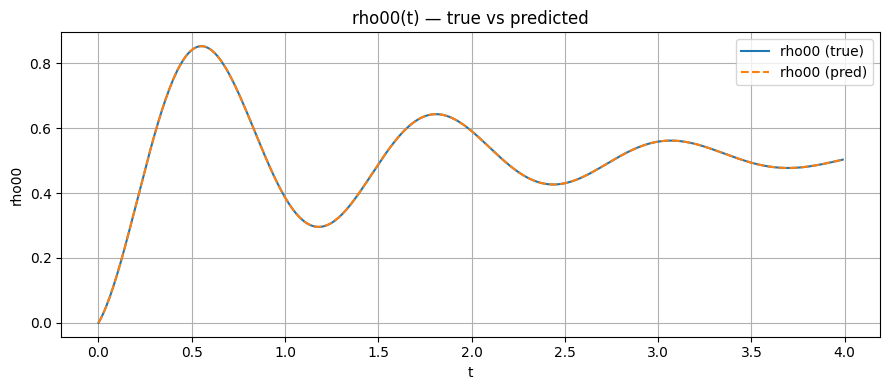

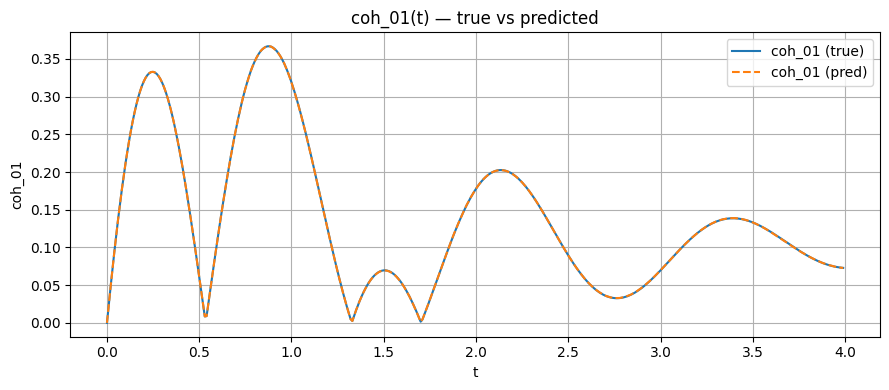

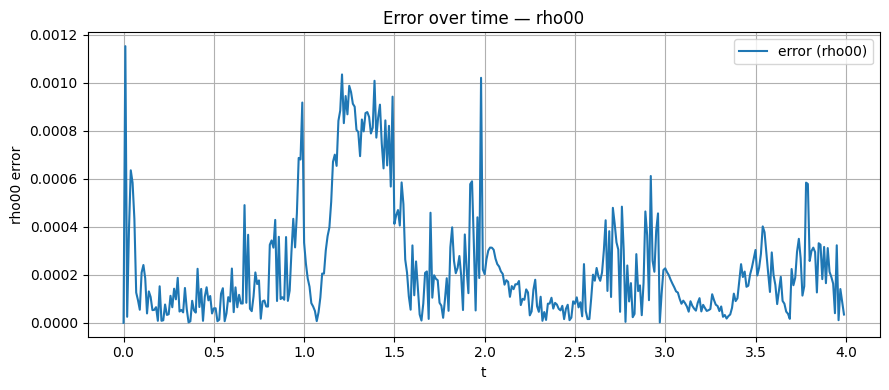

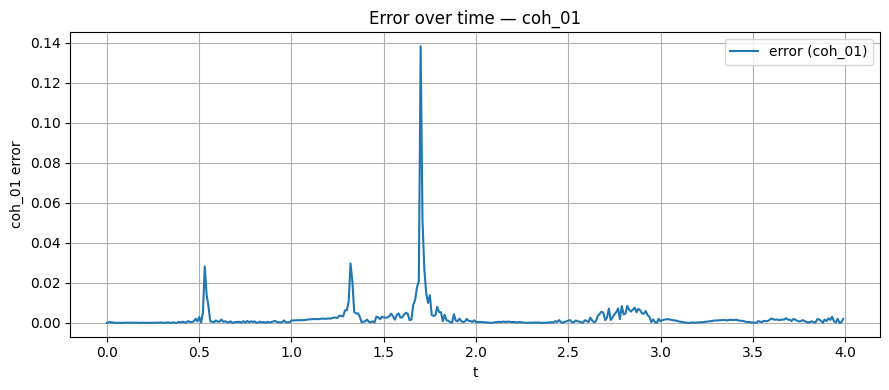

In [145]:
import numpy as onp
import matplotlib.pyplot as plt
import jax

# --- helper to ensure host numpy arrays (works if inputs are JAX DeviceArrays or numpy arrays)
def to_host(a):
    try:
        return onp.asarray(jax.device_get(a))
    except Exception:
        return onp.asarray(a)

# Convert predictions and reference to host numpy
rho00_preds = to_host(rho00_preds)
rho01_re_preds = to_host(rho01_re_preds)
rho01_im_preds = to_host(rho01_im_preds)
coh01_preds = np.abs(rho01_re_preds + 1j*rho01_im_preds)
states = np.array([df['rho_gg'].values, np.abs(df['coh_ge'].values)])
states  = to_host(states)   # expected shape (3, 1000)

print(states.shape)
# print(states[1,:])
# print(states[2,:])

print(np.imag(rho01_re_preds))
print(rho01_im_preds)

# Build time axis that matches predictions.
# Prefer using t_star if available (it was used for the reference states),
# otherwise infer dt = 0.01 (the step you used).

t_axis = onp.array(df['time'][:-1].values)

# final safety checks
N = rho00_preds.shape[0]

print(N)

assert states.shape[1] == N+1, f"Shape mismatch: states has {states.shape[0]} rows but predictions have {N}"

# ------- PLOT: true vs predicted (one figure per variable) -------
vars_pred = [rho00_preds, coh01_preds]
var_names = ['rho00', 'coh_01']

for idx, name in enumerate(var_names):
    plt.figure(figsize=(9,4))

    plt.plot(t_axis, states[idx, :-1], label=f'{name} (true)')
    plt.plot(t_axis, vars_pred[idx], label=f'{name} (pred)', linestyle='--')
    plt.xlabel('t')
    plt.ylabel(name)
    plt.title(f'{name}(t) — true vs predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # If you want to save each figure, uncomment:
    # plt.savefig(f'{name}_true_vs_pred.png', dpi=150)

# ------- PLOT: error over time (one figure per variable) -------
err_rho00 = onp.abs(rho00_preds - states[0, :-1])/(onp.abs(states[0,:-1]) + 1e-12)
err_coh01 = onp.abs(coh01_preds - onp.abs(states[1, :-1]))/(onp.abs(states[1, :-1]) + 1e-12)
errs = [err_rho00, err_coh01]

for idx, name in enumerate(var_names):
    plt.figure(figsize=(9,4))
    plt.plot(t_axis, errs[idx], label=f'error ({name})')
    plt.xlabel('t')
    plt.ylabel(f'{name} error')
    plt.title(f'Error over time — {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # Optional save:
    # plt.savefig(f'{name}_error.png', dpi=150)

# show all figures (in most notebooks this is not necessary, but safe)
plt.show()

vars_pred_mlp = vars_pred
errs_mlp = errs


# PINN with Imporved Architecture
<hr/>

In [9]:
# define modified MLP

def mod_MLP(layers, activation=np.tanh):

    def xavier_init(key, d_in, d_out):

        glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.0)
        W = glorot_stddev * random.normal(key, (d_in, d_out))
        b = np.zeros(d_out)

        return W, b

    def init_layer(key, d_in, d_out):

        k1, _ = random.split(key)

        glorot_stddev = 1.0 / np.sqrt((d_in + d_out)/2.0)

        W = glorot_stddev * random.normal(k1, (d_in, d_out))
        b = np.zeros(d_out)

        return W, b

    def init(rng_key):

        # define U and V of modified input layers
        U1, b1 = xavier_init(random.PRNGKey(12345), layers[0], layers[1])
        U2, b2 = xavier_init(random.PRNGKey(54321), layers[0], layers[1])

        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))

        return (params, U1, b1, U2, b2)

    def apply(params, inputs):

        params, U1, b1, U2, b2 = params

        U = activation(np.dot(inputs, U1) + b1)
        V = activation(np.dot(inputs, U2) + b2)

        for W, b in params[:-1]:
            outputs = activation(np.dot(inputs, W) + b)
            inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V)

        W, b = params[-1]
        outputs = np.dot(inputs, W) + b

        return outputs
    
    return init, apply

In [10]:
class PINN:

    # --------------------------------------------------------------------------------#
    # Properties of the PINN                                                          #
    # --------------------------------------------------------------------------------#
    def __init__(self, layers, states0, t0, t1, tol, threshold=0.99, mod=True):
        
        self.states0 = states0
        self.t0 = t0
        self.t1 = t1

        self.trace_lambda = 0.000001
        self.resid_lambda = 1.0

        # grid
        n_t = 300
        eps = self.t1 * 0.1
        self.t = np.linspace(self.t0, self.t1 + eps, n_t)
        self.threshold = threshold

        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol

        # hamiltonain and meta-parameters
        self.sigma_x = np.array([[0,1],[1,0]], dtype=np.complex64)
        self.omega_x = 2.5
        self.H = self.omega_x * self.sigma_x

        self.sigma_minus = np.array([[0,1],[0, 0]], dtype=np.complex64)
        self.gamma = 1.0
        self.L = self.sigma_minus

        if mod:
            self.init, self.apply = mod_MLP(layers, activation=np.tanh)
        else:
            self.init, self.apply = MLP(layers, activation=np.tanh)

        params = self.init(random.PRNGKey(1234))

        # optimizare properties
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-4, decay_steps=5000, decay_rate=0.9))

        self.opt_state = self.opt_init(params)
        _, self.unravel = ravel_pytree(params)

        # logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_res_log = []


    # --------------------------------------------------------------------------------#
    # Define Nueral Networks and Get Functions                                        #
    # --------------------------------------------------------------------------------#
    def neural_net(self, params, t):

        t = np.stack([t])

        outputs = self.apply(params, t) * t

        rho00 = outputs[0]
        rho01_re = outputs[1]
        rho01_im = outputs[2]

        rho00_ic = self.states0[0]
        rho01_re_ic = self.states0[1]
        rho01_im_ic = self.states0[2]

        rho00 = rho00 + rho00_ic
        rho01 = (rho01_re + rho01_re_ic) + 1j*(rho01_im + rho01_im_ic)

        return rho00, rho01.real, rho01.imag
    
    def rho00_fn(self, params, t):
        rho00 = self.neural_net(params, t)[0]
        return rho00

    def rho01_real_fn(self, params, t):
        rho01_re = self.neural_net(params, t)[1]
        return rho01_re

    def rho01_imag_fn(self, params, t):
        rho01_im = self.neural_net(params, t)[2]
        return rho01_im
    
    # --------------------------------------------------------------------------------#
    # Lindblad Master Equations                                                       #
    # --------------------------------------------------------------------------------#
    def lindblad_rhs(self, rho):

        comm = -1j * (self.H @ rho - rho @ self.H)
        LL = self.L.conj().T @ self.L
        dissipation = self.gamma * (self.L @ rho @ self.L.conj().T - 0.5 * (LL @ rho + rho @ LL))

        return comm + dissipation
      
    def lindblad_loss(self, rho, drho_dt):

        rhs = self.lindblad_rhs(rho)
        R = drho_dt - rhs

        return np.real(np.trace(R.conj().T @ R))


    # --------------------------------------------------------------------------------#
    # Construct Rho and calculate Residual Loss                                       #
    # --------------------------------------------------------------------------------#
    @partial(jit, static_argnums=(0,))
    def residual_net(self, params, t):

        # predictions
        rho00, rho01_re, rho01_im = self.neural_net(params, t)
        rho01 = rho01_re + 1j*rho01_im

        # time derivates
        rho00_t = grad(self.rho00_fn, argnums=1)(params, t)
        rho01_re_t = grad(self.rho01_real_fn, argnums=1)(params, t)
        rho01_im_t = grad(self.rho01_imag_fn, argnums=1)(params, t)
        rho01_t = rho01_re_t + 1j*rho01_im_t

        # conjugates
        rho10 = np.conj(rho01)
        rho10_t = np.conj(rho01_t)

        # build 2x2 complex matrices
        rho = np.array([[rho00, rho01],
                        [rho10, 1 - rho00]], dtype=np.complex64)

        drho_dt = np.array([[rho00_t, rho01_t],
                            [rho10_t, -rho00_t]], dtype=np.complex64)

        loss = self.lindblad_loss(rho, drho_dt)

        # trace loss
        # if self.trace_lambda > 0.0:
        #     tr = np.real(np.trace(rho))
        #     loss = self.resid_lambda * loss + self.trace_lambda * (tr - 1.0)**2

        return 1000*loss
    

    # --------------------------------------------------------------------------------#
    # Causal Training and construction of Different Loss                              #
    # --------------------------------------------------------------------------------#    
    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):

        rho_res = vmap(self.residual_net, (None, 0))(params, self.t)

        W = lax.stop_gradient(np.exp( - tol * self.M @ (rho_res)))

        return rho_res, W
    
    @partial(jit, static_argnums=(0,))
    def loss_res(self, params):

        rho_res, W = self.residuals_and_weights(params, self.tol)
        loss_res = np.mean(W * (rho_res))

        return loss_res
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params):

        loss_res = self.loss_res(params)

        loss = loss_res

        return loss


    # --------------------------------------------------------------------------------#
    # Update/Optimizer step                                                           #
    # --------------------------------------------------------------------------------#
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):

        params = self.get_params(opt_state)
        g = grad(self.loss)(params)

        return self.opt_update(i, g, opt_state)

    # --------------------------------------------------------------------------------#
    # Training Loop                                                                   #
    # --------------------------------------------------------------------------------#
    def train(self, nIter=10000):

        pbar = trange(nIter)

        for it in pbar:

            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)

            if it % 1000 == 0:

                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_res_value = self.loss_res(params)

                _, W_value = self.residuals_and_weights(params, self.tol)

                loss_value.block_until_ready()
                loss_res_value.block_until_ready()
                W_value.block_until_ready()
            
                loss_value_h = float(device_get(loss_value))
                loss_res_value_h = float(device_get(loss_res_value))
                W_value_h = device_get(W_value)

                self.loss_log.append(loss_value_h)
                self.loss_res_log.append(loss_res_value_h)

                pbar.set_postfix({
                    'L' : loss_value_h,
                    'RES' : loss_res_value_h,
                    'W_min' : float(W_value_h.min()),
                })

                if float(W_value_h.min()) > self.threshold:
                    break


    # --------------------------------------------------------------------------------#
    # Predictions                                                                     #
    # --------------------------------------------------------------------------------#
    @partial(jit, static_argnums=(0,))
    def predict_u(self, params, t_star):

        rho00_pred, rho01_re_pred, rho01_im_pred = vmap(self.neural_net, (None, 0))(params, t_star)

        return rho00_pred, rho01_re_pred, rho01_im_pred

In [11]:
t0 = 0.0
t1 = 1.0

tol = 0.1
tol_list = [1e-3, 1e-2, 1e-1, 1e-0] # there was a 1e-3

layers = [1, 128, 128, 128, 3]

rho00_pred_list = []
rho01_re_pred_list = []
rho01_im_pred_list = []
params_list = []
losses_list = []

state0 = np.array([df['rho_gg'][0],df['coh_ge'][0].real, df['coh_ge'][0].imag])
T = 4
t = np.round(np.arange(t0, t1, 0.01),2)

print(t.shape)

state0

(100,)


Array([ 0.,  0., -0.], dtype=float32)

Final Time: 1.0
[ 0.  0. -0.]
tol :  0.001


  7%|▋         | 7000/100000 [00:06<01:20, 1150.00it/s, L=0.0307, RES=0.0307, W_min=0.991]


tol :  0.01


 14%|█▍        | 14000/100000 [00:04<00:26, 3233.35it/s, L=0.00341, RES=0.00341, W_min=0.99] 


tol :  0.1


100%|██████████| 100000/100000 [00:30<00:00, 3234.37it/s, L=0.00178, RES=0.00178, W_min=0.949]


tol :  1.0


100%|██████████| 100000/100000 [00:30<00:00, 3232.25it/s, L=0.00176, RES=0.00176, W_min=0.596]


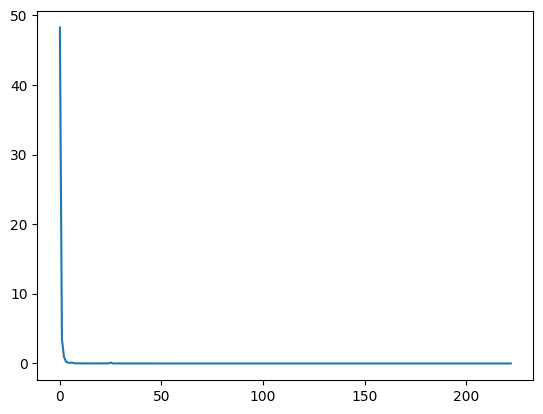

1.0
Relative l2 error rho00: 1.429e-04
Relative l2 error rho01_re: 1.982e+01
Relative l2 error rho01_im: 1.551e-04
Final Time: 2.0
[3.8671649e-01 1.7575920e-05 3.1908911e-01]
tol :  0.001


  4%|▍         | 4000/100000 [00:04<01:59, 804.89it/s, L=0.02, RES=0.02, W_min=0.994]     


tol :  0.01


 14%|█▍        | 14000/100000 [00:04<00:26, 3228.73it/s, L=0.00319, RES=0.00319, W_min=0.991]


tol :  0.1


100%|██████████| 100000/100000 [00:30<00:00, 3233.39it/s, L=0.000731, RES=0.000731, W_min=0.979]


tol :  1.0


100%|██████████| 100000/100000 [00:30<00:00, 3231.76it/s, L=0.000643, RES=0.000643, W_min=0.827]


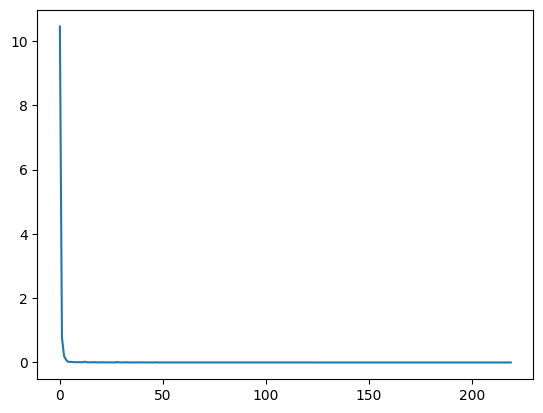

2.0
Relative l2 error rho00: 1.408e-04
Relative l2 error rho01_re: 2.846e+01
Relative l2 error rho01_im: 2.475e-04
Final Time: 3.0
[5.9131944e-01 3.2035634e-05 1.7794867e-01]
tol :  0.001


  4%|▍         | 4000/100000 [00:05<02:00, 795.95it/s, L=0.0249, RES=0.0249, W_min=0.993] 


tol :  0.01


  5%|▌         | 5000/100000 [00:01<00:29, 3228.84it/s, L=0.00339, RES=0.00339, W_min=0.99] 


tol :  0.1


100%|██████████| 100000/100000 [00:30<00:00, 3234.20it/s, L=0.000716, RES=0.000716, W_min=0.979]


tol :  1.0


100%|██████████| 100000/100000 [00:30<00:00, 3233.06it/s, L=0.000556, RES=0.000556, W_min=0.849]


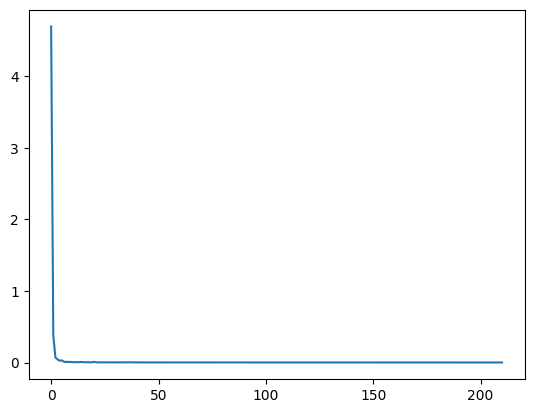

3.0
Relative l2 error rho00: 1.274e-04
Relative l2 error rho01_re: 3.971e+01
Relative l2 error rho01_im: 2.627e-04
Final Time: 4.0
[5.5862761e-01 2.5626272e-05 6.9701478e-02]
tol :  0.001


  6%|▌         | 6000/100000 [00:05<01:24, 1117.38it/s, L=0.0259, RES=0.0259, W_min=0.992]


tol :  0.01


  8%|▊         | 8000/100000 [00:02<00:28, 3232.74it/s, L=0.00324, RES=0.00324, W_min=0.99] 


tol :  0.1


100%|██████████| 100000/100000 [00:30<00:00, 3235.55it/s, L=0.000481, RES=0.000481, W_min=0.986]


tol :  1.0


100%|██████████| 100000/100000 [00:30<00:00, 3235.35it/s, L=0.000352, RES=0.000352, W_min=0.9] 


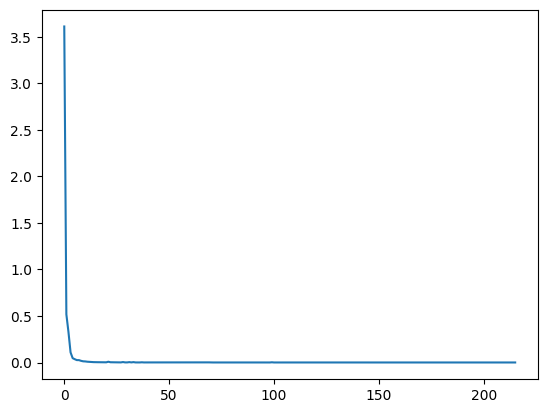

4.0
Relative l2 error rho00: 1.133e-04
Relative l2 error rho01_re: 4.562e+01
Relative l2 error rho01_im: 2.572e-04


In [12]:
loss = []
res = []

for k in range(int(T/t1)):

    # initialize model
    print('Final Time: {}'.format( (k+1) * t1))
    model = PINN(layers, state0, t0, t1, tol)

    print(state0)

    for tol in tol_list:
        model.tol = tol
        print('tol : ', model.tol)

        model.train(nIter=100_000)

    params = model.get_params(model.opt_state)
    rho00_pred, rho01_re_pred, rho01_im_pred = model.predict_u(params, t)
    rho00_0_pred, rho01_0_re_pred, rho01_0_im_pred = model.neural_net(params, model.t1)
    state0 = np.array([rho00_0_pred, rho01_0_re_pred, rho01_0_im_pred])

    # store predictions
    rho00_pred_list.append(rho00_pred)
    rho01_re_pred_list.append(rho01_re_pred)
    rho01_im_pred_list.append(rho01_im_pred)
    losses_list.append(model.loss_res_log)

    # store params
    flat_params, _ = ravel_pytree(params)
    params_list.append(flat_params)

    np.save('rho00_pred_list.npy', rho00_pred_list)
    np.save('rho01_re_pred_list.npy', rho01_re_pred_list)
    np.save('rho01_im_pred_list.npy', rho01_im_pred_list)
    np.save('params_list.npy', params_list)
    np.save('losses_list.npy', onp.array(losses_list, dtype=object), allow_pickle=True)

    plt.plot(np.arange(0, len(model.loss_log), 1),model.loss_log)
    plt.show()

    loss.append(model.loss_log)
    res.append(model.loss_res_log)
    # error
    # Build host (NumPy) concatenated predictions
    rho00_preds = onp.hstack([onp.asarray(x) for x in rho00_pred_list])
    rho01_re_preds = onp.hstack([onp.asarray(z) for z in rho01_re_pred_list])
    rho01_im_preds = onp.hstack([onp.asarray(y) for y in rho01_im_pred_list])

    idx_t0 = df['time'].loc[df['time'] == t0].index[0]

    t_f = onp.round((k+1)*t1 ,2)
    print(t_f)

    idx_t1 = df['time'].loc[df['time'] == t_f].index[0]

    # Get reference states (host numpy)
    states = np.array([df['rho_gg'][idx_t0:idx_t1].values, df['coh_ge'][idx_t0:idx_t1].values.real, df['coh_ge'][idx_t0:idx_t1].values.imag])

    # Compute relative L2 errors with host numpy
    error_rho00 = onp.linalg.norm(rho00_preds - states[0,:]) / onp.linalg.norm(states[0,:])
    error_rho01_re = onp.linalg.norm(rho01_re_preds - states[1,:]) / (onp.linalg.norm(states[1,:]) + 1e-5)
    error_rho01_im = onp.linalg.norm(rho01_im_preds - states[2,:]) / onp.linalg.norm(states[2,:])

    print('Relative l2 error rho00: {:.3e}'.format(error_rho00))
    print('Relative l2 error rho01_re: {:.3e}'.format(error_rho01_re))
    print('Relative l2 error rho01_im: {:.3e}'.format(error_rho01_im))



(2, 401)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

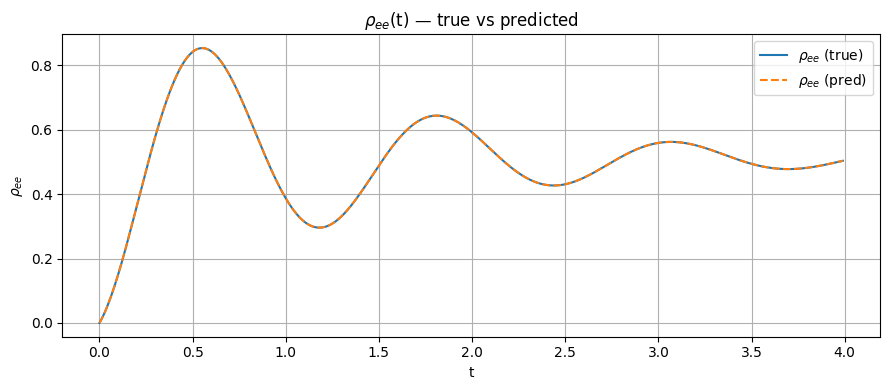

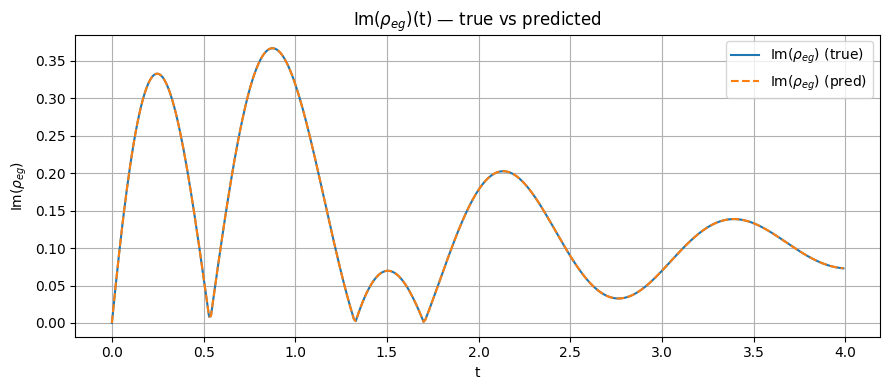

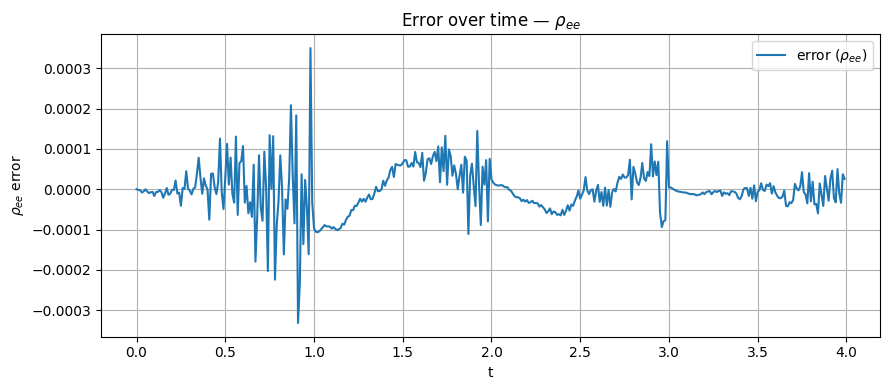

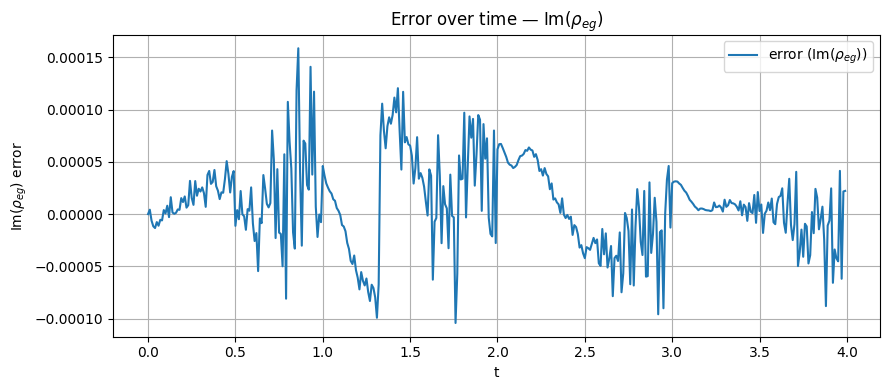

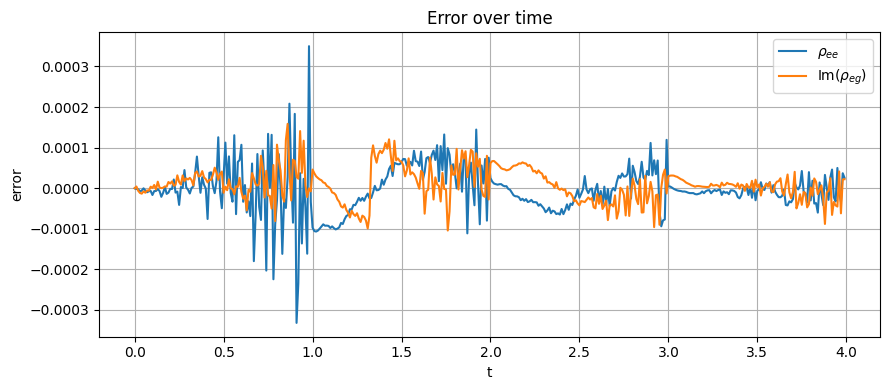

/home/johann/miniconda3/envs/new_base/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/johann/miniconda3/envs/new_base/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


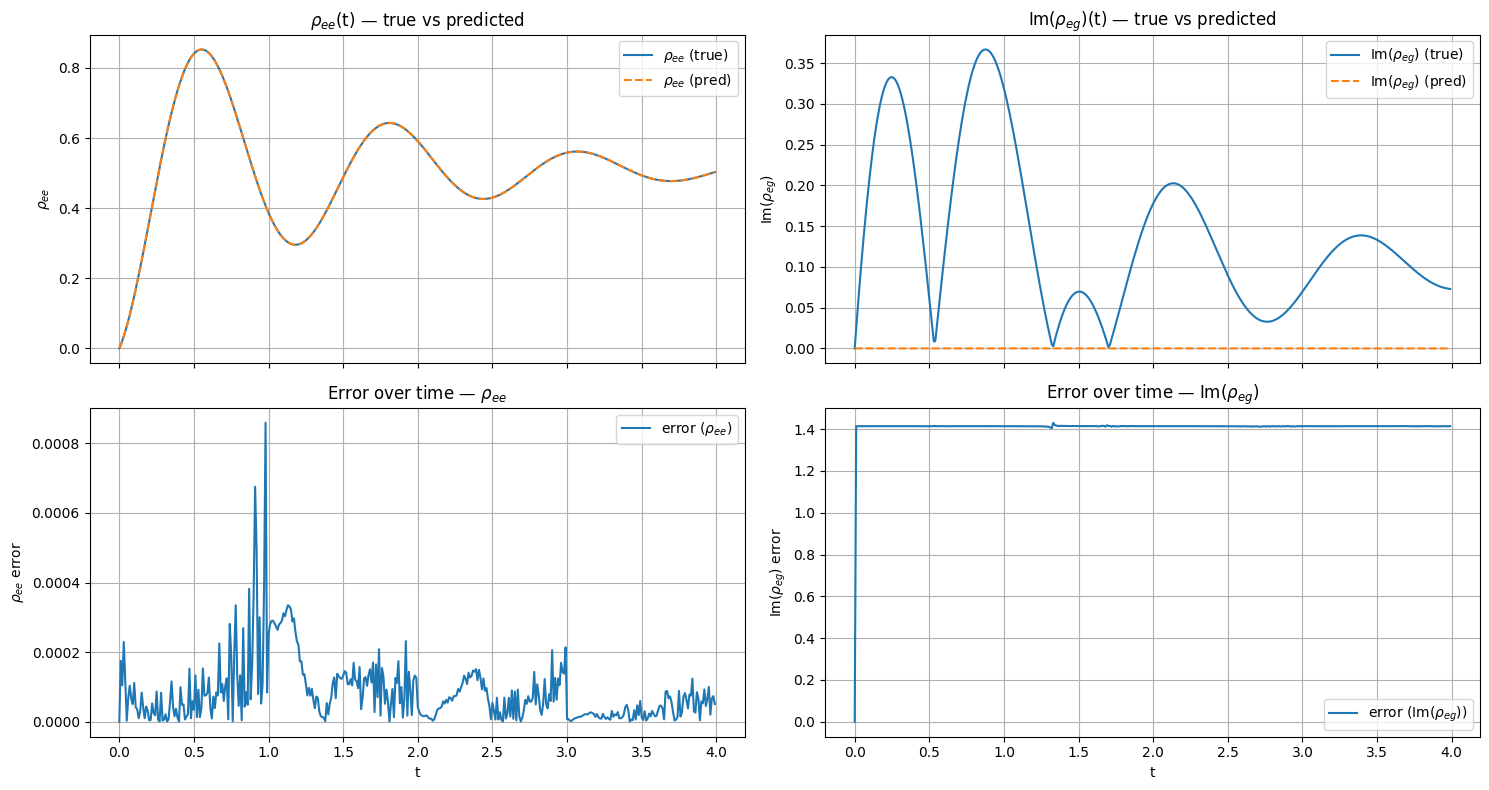

In [ ]:
import numpy as onp
import matplotlib.pyplot as plt
import jax

# --- helper to ensure host numpy arrays (works if inputs are JAX DeviceArrays or numpy arrays)
def to_host(a):
    try:
        return onp.asarray(jax.device_get(a))
    except Exception:
        return onp.asarray(a)

# Convert predictions and reference to host numpy
rho00_preds = to_host(rho00_preds)
rho01_re_preds = to_host(rho01_re_preds)
rho01_im_preds = to_host(rho01_im_preds)
coh01_preds = np.abs(rho01_re_preds + 1j*rho01_im_preds)
states = np.array([df['rho_gg'].values, np.abs(df['coh_ge'].values)])
states  = to_host(states)   # expected shape (3, 1000)

print(states.shape)
# print(states[1,:])
# print(states[2,:])

print(np.imag(rho01_re_preds))
print(rho01_im_preds)

# Build time axis that matches predictions.
# Prefer using t_star if available (it was used for the reference states),
# otherwise infer dt = 0.01 (the step you used).

t_axis = onp.array(df['time'][:-1].values)

# final safety checks
N = rho00_preds.shape[0]

print(N)

assert states.shape[1] == N+1, f"Shape mismatch: states has {states.shape[0]} rows but predictions have {N}"

# ------- PLOT: true vs predicted (one figure per variable) -------
vars_pred = [rho00_preds, coh01_preds]
var_names = [r'$\rho_{ee}$', r'Im($\rho_{eg}$)']

for idx, name in enumerate(var_names):
    plt.figure(figsize=(9,4))

    plt.plot(t_axis, states[idx, :-1], label=f'{name} (true)')
    plt.plot(t_axis, vars_pred[idx], label=f'{name} (pred)', linestyle='--')
    plt.xlabel('t')
    plt.ylabel(name)
    plt.title(f'{name}(t) — true vs predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # If you want to save each figure, uncomment:
    # plt.savefig(f'{name}_true_vs_pred.png', dpi=150)

plt.show()

# ------- PLOT: error over time (one figure per variable) -------
err_rho00 = rho00_preds - states[0,:-1]
err_coh01 = coh01_preds - np.abs(states[1,:-1])
errs = [err_rho00, err_coh01]

for idx, name in enumerate(var_names):
    plt.figure(figsize=(9,4))
    plt.plot(t_axis, errs[idx], label=f'error ({name})')
    plt.xlabel('t')
    plt.ylabel(f'{name} error')
    plt.title(f'Error over time — {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # Optional save:
    # plt.savefig(f'{name}_error.png', dpi=150)

# show all figures (in most notebooks this is not necessary, but safe)
plt.show()

plt.figure(figsize=(9,4))
for idx, name in enumerate(var_names):
    plt.plot(t_axis, errs[idx], label=f'{name}')
    plt.xlabel('t')
    plt.ylabel(f'error')
    plt.title(f'Error over time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # Optional save:
    # plt.savefig(f'{name}_error.png', dpi=150)

# show all figures (in most notebooks this is not necessary, but safe)
plt.show()


# Define variables as given
vars_pred = [rho00_preds, coh01_preds]
var_names = [r'$\rho_{ee}$', r'Im($\rho_{eg}$)']

# Compute errors
err_rho00 = onp.abs(rho00_preds - states[0, :-1])/(onp.abs(states[0,:-1]) + 1e-12)
err_coh01 = onp.abs(coh01_preds - onp.abs(states[1, :-1]))/(onp.abs(states[1, :-1]) + 1e-12)
errs = [err_rho00, err_coh01]

# -------------------------------------------------------
# Create 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

# Top row — true vs predicted
for idx, name in enumerate(var_names):
    ax = axes[0, idx]
    ax.plot(t_axis, states[idx, :-1], label=f'{name} (true)')
    ax.plot(t_axis, vars_pred[idx], label=f'{name} (pred)', linestyle='--')
    ax.set_ylabel(name)
    ax.set_title(f'{name}(t) — true vs predicted')
    ax.legend()
    ax.grid(True)

# Bottom row — errors
for idx, name in enumerate(var_names):
    ax = axes[1, idx]
    ax.plot(t_axis, errs[idx], label=f'error ({name})', color='tab:blue')
    ax.set_xlabel('t')
    ax.set_ylabel(f'{name} error')
    ax.set_title(f'Error over time — {name}')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


# Cheeky Plots
<hr/>

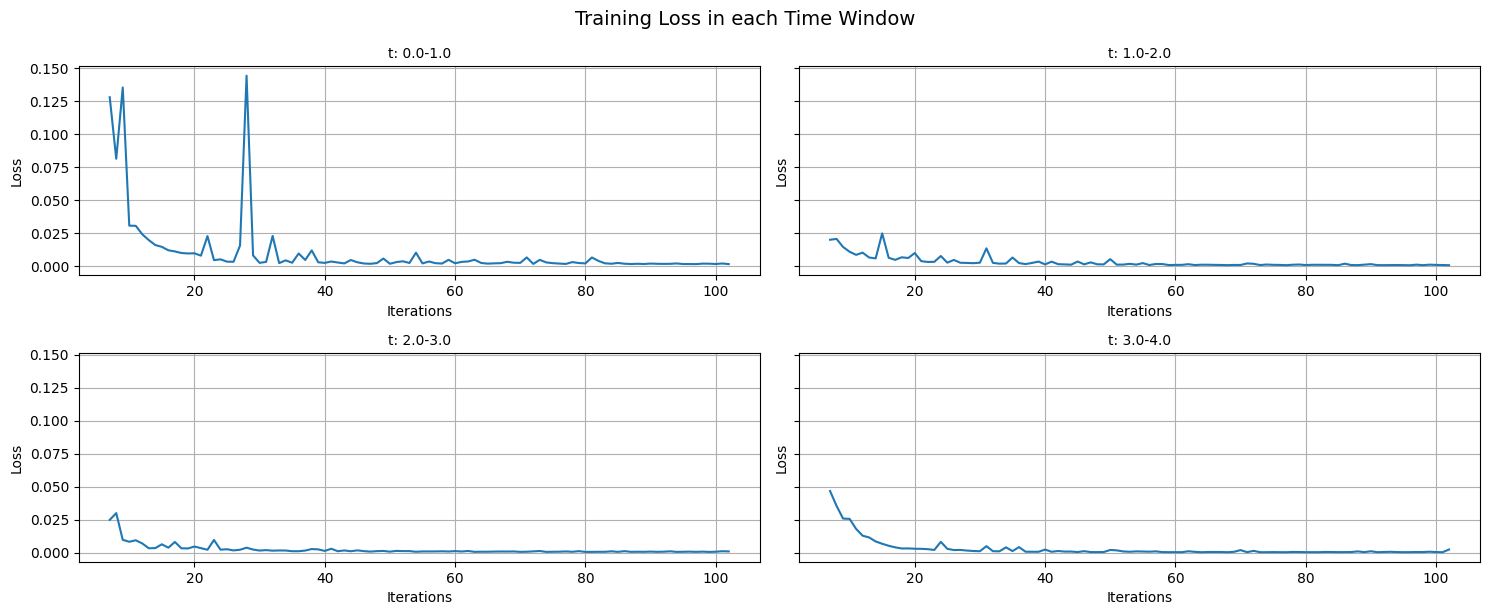

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=False, sharey=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each run and its corresponding subplot
for i, h in enumerate(loss):
    x = onp.arange(3, len(h) + 1)
    axes[i].plot(x[4:100], h[4:100], linewidth=1.5, color='C0')
    axes[i].set_title(f't: {i}.0-{i+1}.0', fontsize=10)
    axes[i].grid(True)
    axes[i].set_xlabel('Iterations')
    axes[i].set_ylabel('Loss')

# Hide any unused subplots (in case there are fewer than 8)
for j in range(len(loss), len(axes)):
    fig.delaxes(axes[j])

# Add an overall title
fig.suptitle('Training Loss in each Time Window', fontsize=14, y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

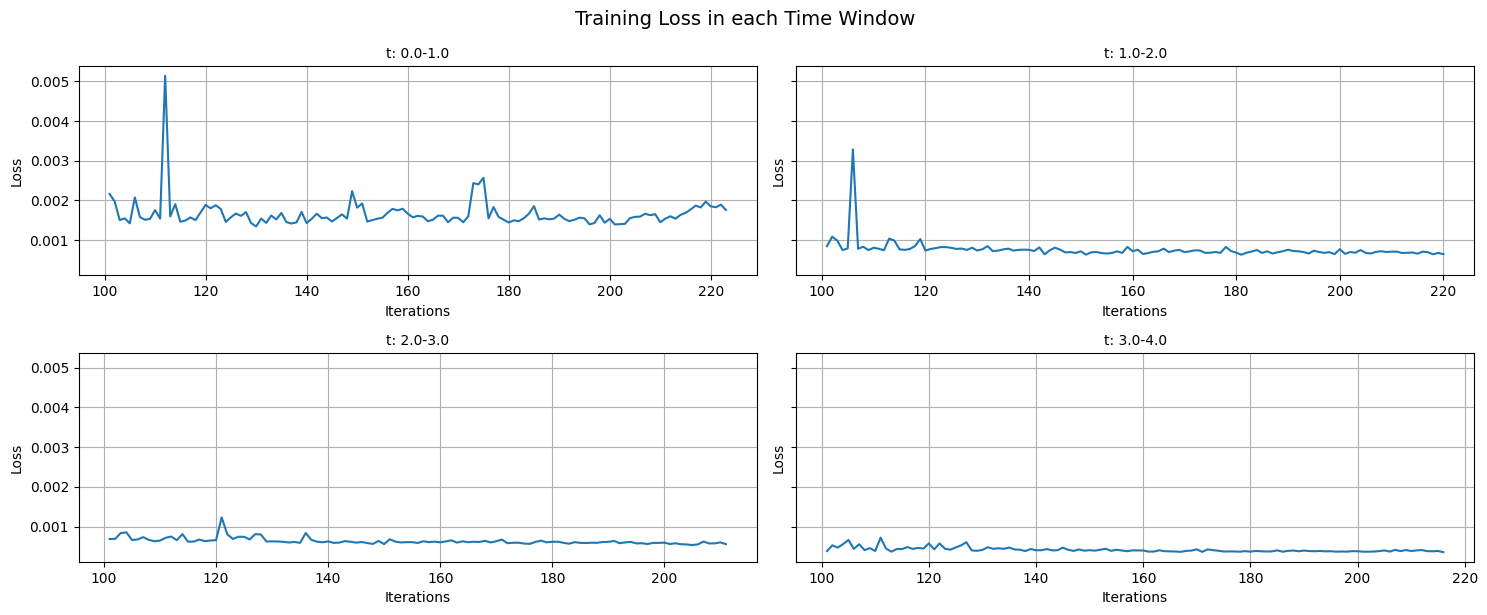

In [15]:
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=False, sharey=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each run and its corresponding subplot
for i, h in enumerate(loss):
    x = onp.arange(3, len(h) + 1)
    axes[i].plot(x[98:], h[100:], linewidth=1.5, color='C0')
    axes[i].set_title(f't: {i}.0-{i+1}.0', fontsize=10)
    axes[i].grid(True)
    axes[i].set_xlabel('Iterations')
    axes[i].set_ylabel('Loss')

# Hide any unused subplots (in case there are fewer than 8)
for j in range(len(loss), len(axes)):
    fig.delaxes(axes[j])

# Add an overall title
fig.suptitle('Training Loss in each Time Window', fontsize=14, y=0.95)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
def plotboy(state0, t1, tol_list, rho00_pred_list=[],rho01_re_pred_list=[],rho01_im_pred_list=[],params_list=[],losses_list=[]):

    for k in range(int(T/t1)):

        # initialize model
        print('Final Time: {}'.format( (k+1) * t1))
        model = PINN(layers, state0, t0, t1, 1, threshold=2, mod=True)

        print(state0)

        for tol in tol_list:
            model.tol = tol
            print('tol : ', model.tol)

            model.train(nIter=100_000)

        params = model.get_params(model.opt_state)
        rho00_pred, rho01_re_pred, rho01_im_pred = model.predict_u(params, t)
        rho00_0_pred, rho01_0_re_pred, rho01_0_im_pred = model.neural_net(params, model.t1)
        state0 = np.array([rho00_0_pred, rho01_0_re_pred, rho01_0_im_pred])

        # store predictions
        rho00_pred_list.append(rho00_pred)
        rho01_re_pred_list.append(rho01_re_pred)
        rho01_im_pred_list.append(rho01_im_pred)
        losses_list.append(model.loss_res_log)

        # store params
        flat_params, _ = ravel_pytree(params)
        params_list.append(flat_params)

        np.save('rho00_pred_list.npy', rho00_pred_list)
        np.save('rho01_re_pred_list.npy', rho01_re_pred_list)
        np.save('rho01_im_pred_list.npy', rho01_im_pred_list)
        np.save('params_list.npy', params_list)
        np.save('losses_list.npy', onp.array(losses_list, dtype=object), allow_pickle=True)

        plt.plot(np.arange(0, len(model.loss_log), 1),model.loss_log)
        plt.show()

        loss.append(model.loss_log)
        res.append(model.loss_res_log)
        # error
        # Build host (NumPy) concatenated predictions
        rho00_preds = onp.hstack([onp.asarray(x) for x in rho00_pred_list])
        rho01_re_preds = onp.hstack([onp.asarray(z) for z in rho01_re_pred_list])
        rho01_im_preds = onp.hstack([onp.asarray(y) for y in rho01_im_pred_list])

        idx_t0 = df['time'].loc[df['time'] == t0].index[0]

        t_f = onp.round((k+1)*t1 ,2)
        print(t_f)

        idx_t1 = df['time'].loc[df['time'] == t_f].index[0]

        print("rho00 shpae ",rho00_preds.shape)

        # Get reference states (host numpy)
        states = np.array([df['rho_gg'][idx_t0:idx_t1].values, df['coh_ge'][idx_t0:idx_t1].values.real, df['coh_ge'][idx_t0:idx_t1].values.imag])

        # Compute relative L2 errors with host numpy
        error_rho00 = onp.linalg.norm(rho00_preds - states[0,:]) / onp.linalg.norm(states[0,:])
        error_rho01_re = onp.linalg.norm(rho01_re_preds - states[1,:]) / (onp.linalg.norm(states[1,:]) + 1e-5)
        error_rho01_im = onp.linalg.norm(rho01_im_preds - states[2,:]) / onp.linalg.norm(states[2,:])

        print('Relative l2 error rho00: {:.3e}'.format(error_rho00))
        print('Relative l2 error rho01_re: {:.3e}'.format(error_rho01_re))
        print('Relative l2 error rho01_im: {:.3e}'.format(error_rho01_im))
    
    # --- helper to ensure host numpy arrays (works if inputs are JAX DeviceArrays or numpy arrays)
    # --- helper to ensure host numpy arrays (works if inputs are JAX DeviceArrays or numpy arrays)
    def to_host(a):
        try:
            return onp.asarray(jax.device_get(a))
        except Exception:
            return onp.asarray(a)

    # Convert predictions and reference to host numpy
    rho00_preds = to_host(rho00_preds)
    rho01_re_preds = to_host(rho01_re_preds)
    rho01_im_preds = to_host(rho01_im_preds)
    coh01_preds = np.abs(rho01_re_preds + 1j*rho01_im_preds)
    states = np.array([df['rho_gg'].values, np.abs(df['coh_ge'].values)])
    states  = to_host(states)   # expected shape (3, 1000)

    print(states.shape)
    # print(states[1,:])
    # print(states[2,:])

    print(np.imag(rho01_re_preds))
    print(rho01_im_preds)

    # Build time axis that matches predictions.
    # Prefer using t_star if available (it was used for the reference states),
    # otherwise infer dt = 0.01 (the step you used).

    t_axis = onp.array(df['time'][:-1].values)

    # final safety checks
    N = rho00_preds.shape[0]

    print(N)

    assert states.shape[1] == N+1, f"Shape mismatch: states has {states.shape[0]} rows but predictions have {N}"


    # Define variables as given
    vp = [rho00_preds, coh01_preds]
    var_names = [r'$\rho_{ee}$', r'Im($\rho_{eg}$)']

    # Compute errors
    err_rho00 = onp.abs(rho00_preds - states[0, :-1])/(onp.abs(states[0,:-1]) + 1e-12)
    err_coh01 = onp.abs(coh01_preds - onp.abs(states[1, :-1]))/(onp.abs(states[1, :-1]) + 1e-12)
    es = [err_rho00, err_coh01]

    # -------------------------------------------------------
    # Create 2×2 grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

    # Top row — true vs predicted
    for idx, name in enumerate(var_names):
        ax = axes[0, idx]
        ax.plot(t_axis, states[idx, :-1], label=f'{name} (true)')
        ax.plot(t_axis, vp[idx], label=f'{name} (pred)', linestyle='--')
        ax.set_ylabel(name)
        ax.set_title(f'{name}(t) — true vs predicted')
        ax.legend()
        ax.grid(True)

    # Bottom row — errors
    for idx, name in enumerate(var_names):
        ax = axes[1, idx]
        ax.plot(t_axis, es[idx], label=f'error ({name})', color='tab:blue')
        ax.set_xlabel('t')
        ax.set_ylabel(f'{name} error')
        ax.set_title(f'Error over time — {name}')
        ax.legend()
        ax.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


    return vp, es


In [17]:


state0 = np.array([df['rho_gg'][0],df['coh_ge'][0].real, df['coh_ge'][0].imag])
vars_pred_no_causal, errs_no_causal = plotboy(state0=state0,t1=4, tol_list=tol_list)


Final Time: 4
[ 0.  0. -0.]
tol :  0.001


 33%|███▎      | 32655/100000 [00:13<00:28, 2391.52it/s, L=1.4, RES=1.4, W_min=0.582]     


KeyboardInterrupt: 

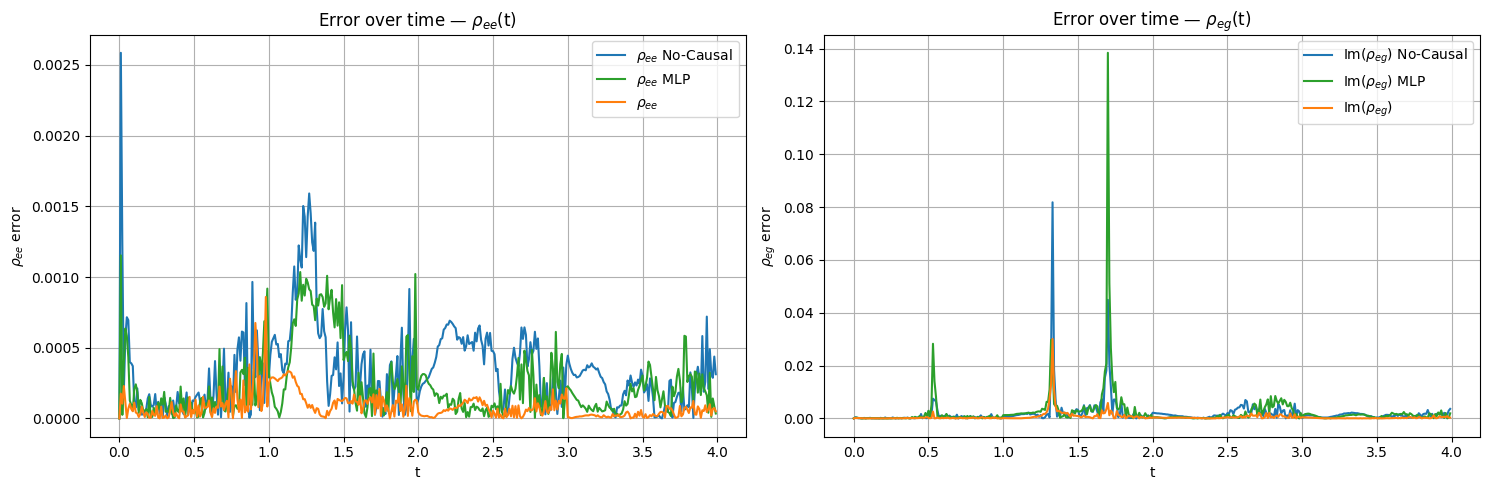

In [ ]:
t_axis = onp.array(df['time'][:-1].values)

vars_pred = onp.concat([vars_pred, vars_pred_no_causal])
errs = onp.concat([errs, errs_no_causal])
var_names = [r'$\rho_{ee}$', r'Im($\rho_{eg}$)',r'$\rho_{ee}$ MLP', r'Im($\rho_{eg}$) MLP',r'$\rho_{ee}$ No-Causal', r'Im($\rho_{eg}$) No-Causal']

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Top row — true vs predicted

ax = axes[0]
ax.plot(t_axis, errs[4], label=f'{var_names[4]}', color='tab:blue')
ax.plot(t_axis, errs[2], label=f'{var_names[2]}', color='tab:green')
ax.plot(t_axis, errs[0], label=f'{var_names[0]}', color='tab:orange')
ax.set_xlabel('t')
ax.set_ylabel(r'$\rho_{ee}$ error')
ax.set_title(r'Error over time — $\rho_{ee}$(t)')
ax.legend()
ax.grid(True)


ax = axes[1]
ax.plot(t_axis, errs[5], label=f'{var_names[5]}', color='tab:blue')
ax.plot(t_axis, errs[3], label=f'{var_names[3]}', color='tab:green')
ax.plot(t_axis, errs[1], label=f'{var_names[1]}', color='tab:orange')
ax.set_xlabel('t')
ax.set_ylabel(r'$\rho_{eg}$ error')
ax.set_title(r'Error over time — $\rho_{eg}$(t)')
ax.legend()
ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

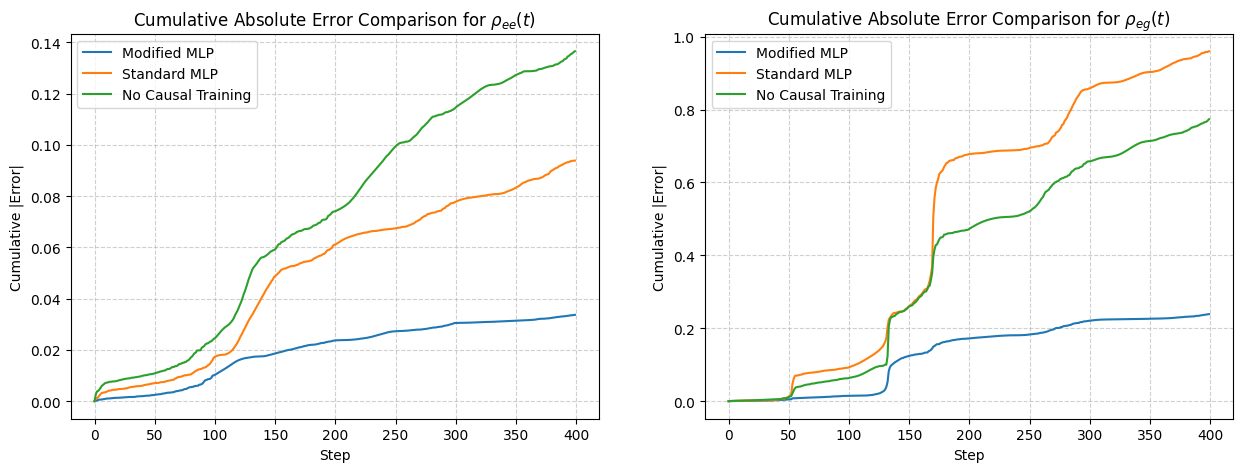

In [ ]:
import numpy as onp
import matplotlib.pyplot as plt

# Example: assume errs, errs_mlp, and errs_no_causal are numpy arrays
# Each array contains possibly negative error values

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Compute cumulative sum of absolute errors
cum_errs_1 = onp.cumsum(onp.abs(errs[0]))
cum_errs_mlp_1 = onp.cumsum(onp.abs(errs_mlp[0]))
cum_errs_no_causal_1 = onp.cumsum(onp.abs(errs_no_causal[0]))

ax = axes[0]
# Plot all three on the same figure
ax.plot(cum_errs_1, label='Modified MLP')
ax.plot(cum_errs_mlp_1, label='Standard MLP')
ax.plot(cum_errs_no_causal_1, label='No Causal Training')
ax.set_xlabel('Step')
ax.set_ylabel('Cumulative |Error|')
ax.set_title(r'Cumulative Absolute Error Comparison for $\rho_{ee}(t)$')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

cum_errs_2 = onp.cumsum(onp.abs(errs[1]))
cum_errs_mlp_2 = onp.cumsum(onp.abs(errs_mlp[1]))
cum_errs_no_causal_2 = onp.cumsum(onp.abs(errs_no_causal[1]))

ax=axes[1]
# Plot all three on the same figure
ax.plot(cum_errs_2, label='Modified MLP')
ax.plot(cum_errs_mlp_2, label='Standard MLP')
ax.plot(cum_errs_no_causal_2, label='No Causal Training')
ax.set_xlabel('Step')
ax.set_ylabel('Cumulative |Error|')
ax.set_title(r'Cumulative Absolute Error Comparison for $\rho_{eg}(t)$')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
